In [72]:
import pandas as pd
from datetime import datetime   

df_daily=pd.read_csv('/home/nightrose/Documents/Github/try/xyz/data.daily.csv', sep='\t') 
df_daily.time=pd.to_datetime(df_daily.time,unit='D',format='%Y-%m-%d')
df_daily=pd.DataFrame(df_daily)
df_daily['time']=[x.strftime('%m/%d/%Y') for x in df_daily['time']]
df_daily['volume']=100
df_daily['symbol']='CUBS'
df_daily = df_daily[['symbol','time', 'open', 'high','low','close','volume']]
df_daily.rename(columns={'symbol': 'symbol','time': 'dt', 'open':'open','high':'high','low':'low','close':'close',
                        'volume':'volume'}, inplace=True)

#df_daily=df_daily.set_index('dt')
print(df_daily.head())
df_daily.to_csv('/home/nightrose/Documents/Github/try/xyz/data_daily.csv', sep=',',header=False,index=False)

  symbol          dt    open    high     low   close  volume
0   CUBS  01/08/1990  411.25  412.00  410.00  410.00     100
1   CUBS  01/09/1990  408.25  408.50  406.25  406.75     100
2   CUBS  01/10/1990  406.00  406.25  403.25  405.50     100
3   CUBS  01/11/1990  406.75  407.00  403.25  404.50     100
4   CUBS  01/12/1990  406.75  406.75  400.75  402.00     100


[2016-02-15 21:35] INFO: Performance: Simulated 4 trading days out of 4.
[2016-02-15 21:35] INFO: Performance: first open: 2012-04-10 13:31:00+00:00
[2016-02-15 21:35] INFO: Performance: last close: 2012-04-13 20:00:00+00:00


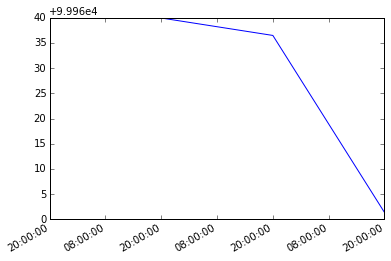

In [25]:
"""
Read in custom csv files
"""
import pandas as pd
from zipline.gens.utils import hash_args
from zipline.sources.data_source import DataSource
import datetime
import csv
import numpy as np
from zipline.algorithm import TradingAlgorithm
from pandas.tseries.tools import to_datetime
import matplotlib.pyplot as plt
%matplotlib inline

def get_time(time_str):
    time_array = map(int, time_str.split(":"))
    assert len(time_array) == 2
    assert time_array[0] < 24 and time_array[1] < 61
    return datetime.time(time_array[0], time_array[1])


def gen_ts(date, time):
    return pd.Timestamp(datetime.datetime.combine(date, time))


class DatasourceCSVohlc(DataSource):
    """ expects dictReader for a csv file
     with the following columns (no header)
    symbol,dt, open, high, low, close, volume
    separated by comma,
    dt expected in ISO format and order does not matter"""
    def __init__(self, filename, **kwargs):
        self.filename = filename
        # Unpack config dictionary with default values.
        if 'symbols' in kwargs:
            self.sids = kwargs.get('symbols')
        else:
            self.sids = None
        self.tz_in = kwargs.get('tz_in', "US/Eastern")
        self.start = pd.Timestamp(to_datetime(kwargs.get('start'))).tz_localize('utc')
        self.end = pd.Timestamp(to_datetime(kwargs.get('end'))).tz_localize('utc')
        self._raw_data = None
        self.arg_string = hash_args(filename, **kwargs)

    @property
    def instance_hash(self):
        return self.arg_string

    def raw_data_gen(self):
        previous_ts = None
        with open(self.filename, 'rb') as csvfile:
            self.data = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in self.data:
                ts = pd.Timestamp(to_datetime(row[1])).tz_localize('utc')
                if ts < self.start or ts > self.end:
                    continue
                volumes = {}
                price_volumes = {}
                sid = row[0]
                if self.sids is None or sid in self.sids:
                    if sid not in volumes:
                        volumes[sid] = 0
                        price_volumes[sid] = 0
                        event = {"sid": sid, "type": "TRADE", "symbol": sid}
                        cols = ["open", "high", "low", "close"]
                        event["dt"] = ts
                        event["price"] = float(row[5])
                        event["volume"] = row[6]
                        volumes[sid] += float(event["volume"])
                        price_volumes[sid] += event["price"] * float(event["volume"])
                        event["vwap"] = price_volumes[sid] / volumes[sid]
                        event["open"] = row[2]
                        event["high"] = row[3]
                        event["low"] = row[4]
                        event["close"] = row[5]
                        yield event

    @property
    def raw_data(self):
        if not self._raw_data:
            self._raw_data = self.raw_data_gen()
        return self._raw_data

    @property
    def mapping(self):
        return {
            'sid': (lambda x: x, 'sid'),
            'dt': (lambda x: x, 'dt'),
            'open': (float, 'open'),
            'high': (float, 'high'),
            'low': (float, 'low'),
            'close': (float, 'close'),
            'price': (float, 'price'),
            'volume': (int, 'volume'),
            'vwap': (lambda x: x, 'vwap')
        }



[2016-02-15 22:11] INFO: Performance: Simulated 4 trading days out of 4.
[2016-02-15 22:11] INFO: Performance: first open: 2012-04-10 13:31:00+00:00
[2016-02-15 22:11] INFO: Performance: last close: 2012-04-13 20:00:00+00:00


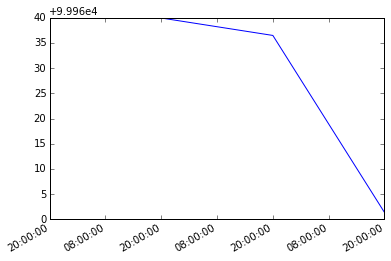

In [69]:
class BuyApple(TradingAlgorithm):  # inherit from TradingAlgorithm
    """This is the simplest possible algorithm that does nothing but
    buy 1 apple share on each event.
    """
    def initialize(self):
        pass

    def handle_data(self, data):  # overload handle_data() method
        self.order('AAPL', 1)  # order SID (=0) and amount (=1 shares)
        
if __name__ == "__main__":
    source = DatasourceCSVohlc('/home/nightrose/Documents/Github/try/xyz/AAPL.csv', symbols='AAPL', 
                               start='2012-04-10', end='2012-04-13')
    simple_algo = BuyApple()
    results = simple_algo.run(source)
    results.portfolio_value.plot()

[2016-02-15 22:13] INFO: Performance: Simulated 63 trading days out of 63.
[2016-02-15 22:13] INFO: Performance: first open: 2009-01-12 14:31:00+00:00
[2016-02-15 22:13] INFO: Performance: last close: 2009-04-13 20:00:00+00:00


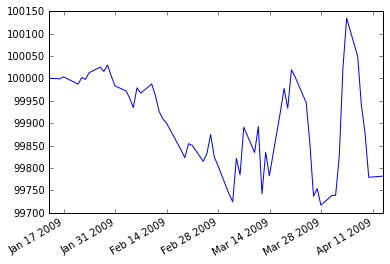

In [74]:
class BuyCubist(TradingAlgorithm):  # inherit from TradingAlgorithm
    """This is the simplest possible algorithm that does nothing but
    buy 1 apple share on each event.
    """
    def initialize(self):
        pass

    def handle_data(self, data):  # overload handle_data() method
        self.order('CUBS', 1)  # order SID (=0) and amount (=1 shares)
        
if __name__ == "__main__":
    source = DatasourceCSVohlc('/home/nightrose/Documents/Github/try/xyz/data_daily.csv', symbols='CUBS', 
                               start='2009-01-10', end='2009-04-13')
    simple_algo = BuyCubist()
    results = simple_algo.run(source)
    results.portfolio_value.plot()


In [75]:
results

,capital_used,ending_cash,ending_value,orders,period_close,period_open,pnl,portfolio_value,positions,returns,starting_cash,starting_value,transactions
2009-01-12 21:00:00,0.000000,100000.000000,0.000000,"[{u'status': 0, u'created': 2009-01-12 00:00:0...",2009-01-12 21:00:00+00:00,2009-01-12 14:31:00+00:00,0.000000,100000.000000,[],0.000000e+00,100000.000000,0.000000,[]
2009-01-13 21:00:00,-81.261532,99918.738468,81.230720,"[{u'status': 1, u'created': 2009-01-12 00:00:0...",2009-01-13 21:00:00+00:00,2009-01-13 14:31:00+00:00,-0.030812,99999.969188,"[{u'amount': 1, u'last_sale_price': 81.2307196...",-3.081231e-07,100000.000000,0.000000,"[{u'commission': 0.03, u'amount': 1, u'sid': u..."
2009-01-14 21:00:00,-81.261532,99837.476936,162.461439,"[{u'status': 1, u'created': 2009-01-13 00:00:0...",2009-01-14 21:00:00+00:00,2009-01-14 14:31:00+00:00,-0.030812,99999.938375,"[{u'amount': 2, u'last_sale_price': 81.2307196...",-3.081232e-07,99918.738468,81.230720,"[{u'commission': 0.03, u'amount': 1, u'sid': u..."
2009-01-15 21:00:00,-80.764486,99756.712450,242.201036,"[{u'status': 1, u'created': 2009-01-14 00:00:0...",2009-01-15 21:00:00+00:00,2009-01-15 14:31:00+00:00,-1.024890,99998.913486,"[{u'amount': 3, u'last_sale_price': 80.7336785...",-1.024890e-05,99837.476936,162.461439,"[{u'commission': 0.03, u'amount': 1, u'sid': u..."
2009-01-16 21:00:00,-82.397637,99674.314813,329.467254,"[{u'status': 1, u'created': 2009-01-15 00:00:0...",2009-01-16 21:00:00+00:00,2009-01-16 14:31:00+00:00,4.868582,100003.782067,"[{u'amount': 4, u'last_sale_price': 82.3668136...",4.868635e-05,99756.712450,242.201036,"[{u'commission': 0.03, u'amount': 1, u'sid': u..."
2009-01-20 21:00:00,-78.279255,99596.035558,391.242365,"[{u'status': 1, u'created': 2009-01-16 00:00:0...",2009-01-20 21:00:00+00:00,2009-01-20 14:31:00+00:00,-16.504145,99987.277922,"[{u'amount': 5, u'last_sale_price': 78.2484729...",-1.650352e-04,99674.314813,329.467254,"[{u'commission': 0.03, u'amount': 1, u'sid': u..."
2009-01-21 21:00:00,-81.261532,99514.774026,487.384318,"[{u'status': 1, u'created': 2009-01-20 00:00:0...",2009-01-21 21:00:00+00:00,2009-01-21 14:31:00+00:00,14.880421,100002.158343,"[{u'amount': 6, u'last_sale_price': 81.2307196...",1.488231e-04,99596.035558,391.242365,"[{u'commission': 0.03, u'amount': 1, u'sid': u..."
2009-01-22 21:00:00,-80.551466,99434.222560,563.644626,"[{u'status': 1, u'created': 2009-01-21 00:00:0...",2009-01-22 21:00:00+00:00,2009-01-22 14:31:00+00:00,-4.291158,99997.867186,"[{u'amount': 7, u'last_sale_price': 80.5206608...",-4.291065e-05,99514.774026,487.384318,"[{u'commission': 0.03, u'amount': 1, u'sid': u..."
2009-01-23 21:00:00,-82.681664,99351.540896,661.206697,"[{u'status': 1, u'created': 2009-01-22 00:00:0...",2009-01-23 21:00:00+00:00,2009-01-23 14:31:00+00:00,14.880407,100012.747593,"[{u'amount': 8, u'last_sale_price': 82.6508371...",1.488072e-04,99434.222560,563.644626,"[{u'commission': 0.03, u'amount': 1, u'sid': u..."
2009-01-26 21:00:00,-84.243808,99267.297087,757.916697,"[{u'status': 1, u'created': 2009-01-23 00:00:0...",2009-01-26 21:00:00+00:00,2009-01-26 14:31:00+00:00,12.466192,100025.213784,"[{u'amount': 9, u'last_sale_price': 84.2129663...",1.246460e-04,99351.540896,661.206697,"[{u'commission': 0.03, u'amount': 1, u'sid': u..."
